# 🧠 Классификация отзывов о фильмах (IMDB) с помощью логистической регрессии

В этом ноутбуке мы обучим модель логистической регрессии для анализа текстов отзывов на фильмы из базы данных IMDB и определения их тональности — положительная или отрицательная.

Мы также посмотрим, какие слова вносят наибольший вклад в классификацию, и визуализируем это влияние.

## 📥 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# Загрузка датасета
movies = pd.read_csv("data/IMDB_Dataset.csv")

# Просмотр первых строк
movies

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 🏷️ 2. Преобразование меток: 'positive' → 1, 'negative' → 0

In [3]:
# Преобразуем текстовые метки в числовые значения
movies['sentiment'] = movies['sentiment'].map({'positive': 1, 'negative': 0})
movies

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


## 🧾 3. Векторизация текста (мешок слов)

Мы создадим признаки на основе слов, встречающихся в отзывах. Для ускорения работы ограничим словарь 2000 наиболее частыми словами и удалим стоп-слова.

In [4]:
vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(movies['review'])  # матрица признаков
y = movies['sentiment']                         # целевые значения

## 🤖 4. Обучение модели логистической регрессии

In [5]:
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 🧩 5. Извлечение весов признаков (слов)

Каждое слово в модели имеет вес (коэффициент), отражающий его вклад в предсказание **положительного** класса. Мы проанализируем эти веса.

In [6]:
# Получаем список слов (признаков)
feature_names = vectorizer.get_feature_names_out()
word_weights = model.coef_[0]

# Создаём таблицу: слово — вес
word_sentiments = pd.DataFrame({
    'word': feature_names,
    'weight': word_weights
})

word_sentiments

,word,weight
0,000,-0.127756
1,10,0.176485
2,100,0.173360
3,11,0.172752
4,12,0.066440
...,...,...
1995,younger,-0.141749
1996,youth,0.102892
1997,zero,-0.311422
1998,zombie,-0.013555


## 🔝 6. Топ-10 положительных и отрицательных слов

In [7]:
# Наиболее положительные слова
most_positive = word_sentiments.sort_values('weight', ascending=False).head(10)

# Наиболее отрицательные слова
most_negative = word_sentiments.sort_values('weight').head(10)

# Печать
print("Топ-10 положительных слов:")
display(most_positive)

print("\nТоп-10 отрицательных слов:")
display(most_negative)

Топ-10 положительных слов:


,word,weight
1964,wonderfully,1.401081
735,funniest,1.175639
747,gem,1.167037
221,brilliantly,1.120201
1707,subtle,1.086720
1720,superb,1.052533
595,excellent,1.041634
686,finest,1.016542
449,delightful,1.015959
1853,underrated,0.982898



Топ-10 отрицательных слов:


,word,weight
1921,waste,-1.913990
491,disappointment,-1.701778
1977,worst,-1.572182
1009,laughable,-1.475656
1858,unfunny,-1.471278
517,dreadful,-1.468136
142,awful,-1.444341
1337,poorly,-1.418708
1440,redeeming,-1.417108
1756,tedious,-1.403754


## 📊 7. Визуализация ключевых слов

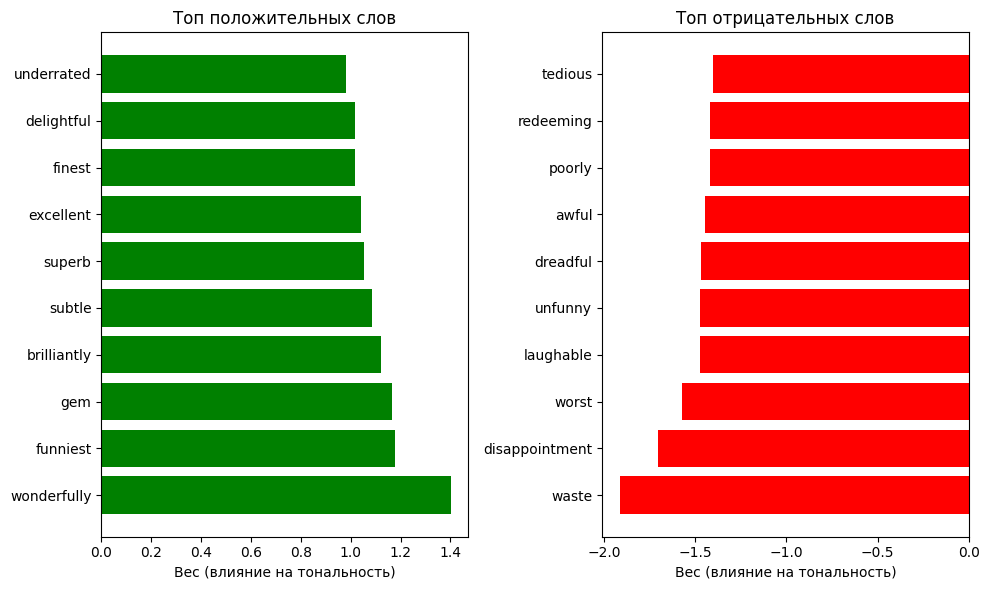

In [8]:
plt.figure(figsize=(10, 6))

# Положительные
plt.subplot(121)
plt.barh(most_positive['word'], most_positive['weight'], color='green')
plt.title('Топ положительных слов')
plt.xlabel('Вес (влияние на тональность)')

# Отрицательные
plt.subplot(122)
plt.barh(most_negative['word'], most_negative['weight'], color='red')
plt.title('Топ отрицательных слов')
plt.xlabel('Вес (влияние на тональность)')

plt.tight_layout()
plt.show()

## 📈 8. Предсказание вероятности позитивной тональности

In [9]:
# Предсказание вероятностей (0...1) для всех отзывов
predictions = model.predict_proba(X)[:, 1]

# Добавим предсказания в датафрейм
movies['predictions'] = predictions

## 🔍 9. Самые позитивные и самые негативные отзывы

In [10]:
# Самый позитивный отзыв
most_positive_review = movies.sort_values('predictions', ascending=False).head(1)

# Самый негативный отзыв
most_negative_review = movies.sort_values('predictions').head(1)

print("Самый позитивный отзыв:")
display(most_positive_review)

print("\nСамый негативный отзыв:")
display(most_negative_review)

Самый позитивный отзыв:


,review,sentiment,predictions
42946,By now you've probably heard a bit about the n...,1,1.0



Самый негативный отзыв:


,review,sentiment,predictions
13452,Zombi 3 starts as a group of heavily armed men...,0,2.565738e-17


## 📝 10. Текст лучшего и худшего отзыва

In [11]:
print("Текст самого позитивного отзыва:")
print(most_positive_review['review'].iloc[0])

Текст самого позитивного отзыва:
By now you've probably heard a bit about the new Disney dub of Miyazaki's classic film, Laputa: Castle In The Sky. During late summer of 1998, Disney released "Kiki's Delivery Service" on video which included a preview of the Laputa dub saying it was due out in "1999". It's obviously way past that year now, but the dub has been finally completed. And it's not "Laputa: Castle In The Sky", just "Castle In The Sky" for the dub, since Laputa is not such a nice word in Spanish (even though they use the word Laputa many times throughout the dub). You've also probably heard that world renowned composer, Joe Hisaishi, who scored the movie originally, went back to rescore the excellent music with new arrangements. Laputa came out before My Neighbor Totoro and after Nausicaa of the Valley of the Wind, which began Studio Ghibli and it's long string of hits. And in my opinion, I think it's one of Miyazaki's best films with a powerful lesson tuckered inside this two

In [12]:
print("\nТекст самого негативного отзыва:")
print(most_negative_review['review'].iloc[0])


Текст самого негативного отзыва:
Zombi 3 starts as a group of heavily armed men steal a experimental chemical developed to reanimate the dead, while trying to escape the man is shot at & the metal container holding the chemical is breached. The man gets some of the green chemical on a wound on his hand which soon after turns him into a flesh eating cannibalistic zombie. Within hours the surrounding area is crawling with the flesh easting undead on the look out for fresh victims, Kenny (Deran Sarafian) & his army buddies find themselves in big trouble as they stop to help Patricia (Beatrice Ring) & her friend Lia (Deborah Bergammi) who has been pecked by zombie birds (!). General Morton is in charge of the situation & has to stop the zombie plague from spread throughout the whole world! But will he & his men succeed?<br /><br />This Italian produced film was to be directed by Italian zombie gore film auteur Lucio Fulci but the story goes he suffered a stroke & therefore couldn't finish

## ✅ Выводы

* Мы построили простую, но интерпретируемую модель классификации отзывов.
* Наиболее "позитивные" слова включают: `wonderfully`, `funniest`, `gem` и др.
* Наиболее "негативные": `waste`, `disappointment`, `worst`.
* Модель позволяет также находить самые "позитивные" и "негативные" тексты.